In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [70]:
#df = pd.read_csv('../data/full_data_interaction_05_025.csv')
#df = pd.read_csv('../data/full_data_interaction_01_075.csv')
df = pd.read_csv('../data/full_data_interaction_025_075.csv')

In [71]:
df.shape

(3015, 101)

In [14]:
X = df.drop(columns = ['state', 'county_name', 'unemployment_rate_2010', 'population_total_2010'])
y = df['unemployment_rate_2010']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

### Linear Regression on original data

In [64]:
df_lin_reg = pd.read_csv('../data/final_work_data.csv')

In [65]:
df_lin_reg.head()

,state,county_name,unemployment_rate_2010,population_total_2010,urban_population_prc,rural_population_prc,crime_per_capita,per_capita_sme_num,per_capita_large_num,avg_ann_pay_per_emp_sme,...,popul_college_grad_prc,popul_single_paren_prc,liquor_stores_per10k,police_per_1000,WhiteNonHispanicPct2010,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010
0,AL,Autauga,8.8,54571.0,0.579978,0.420022,0.002620,0.012259,0.002565,22667.03037,...,0.21,0.09,0.4,1.172784,77.25,17.58,0.86,0.40,2.40,1.59
1,AL,Baldwin,9.9,182265.0,0.577209,0.422791,0.002112,0.020108,0.002019,28664.84962,...,0.26,0.09,0.8,1.486846,83.50,9.31,0.74,0.63,4.38,1.49
2,AL,Barbour,12.1,27457.0,0.322104,0.677896,0.000911,0.015042,0.002586,25720.31403,...,0.11,0.14,1.1,3.177696,46.75,46.69,0.39,0.22,5.05,0.94
3,AL,Bibb,11.2,22915.0,0.316474,0.683526,0.002575,0.011172,0.000916,27318.29733,...,0.11,0.05,0.5,0.523674,75.02,21.92,0.10,0.28,1.77,0.89
4,AL,Blount,9.7,57322.0,0.100485,0.899515,0.000419,0.010485,0.001082,26050.59382,...,0.12,0.07,0.0,0.854820,88.89,1.26,0.20,0.50,8.07,1.19


In [66]:
lin_reg = LinearRegression()
X = df_lin_reg.drop(columns=['state', 'county_name', 'unemployment_rate_2010', 'population_total_2010'])
y = df_lin_reg['unemployment_rate_2010']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, random_state=42)
lin_reg.fit(X_train_lr, y_train_lr)

LinearRegression()

In [67]:
lin_reg.score(X_train_lr, y_train_lr),lin_reg.score(X_test_lr, y_test_lr), cross_val_score(lin_reg, X_train_lr, y_train_lr).mean() 

(0.4299423542202645, 0.39382629086847676, 0.3593874243714773)

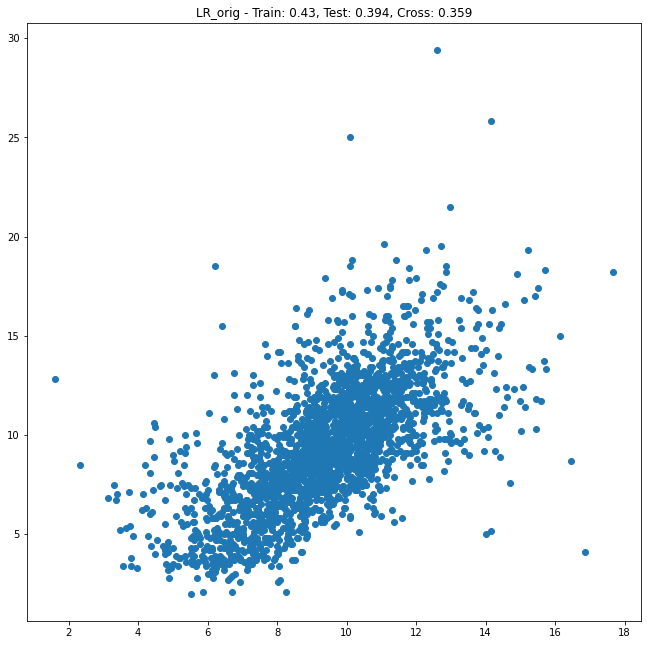

In [68]:

plt.figure(figsize=(11,11))
plt.scatter(lin_reg.predict(X_train_lr), y_train_lr)
plt.title('LR_orig - Train: 0.43, Test: 0.394, Cross: 0.359')
plt.savefig('../graphs/LR_orig_pred_scatter.jpg')

### Linear Regression on preporcessed data

In [22]:
lr = LinearRegression()
lr.fit(Z_train, y_train)

LinearRegression()

In [23]:
lr.score(Z_train, y_train), lr.score(Z_test, y_test), cross_val_score(lr, Z_train, y_train).mean()

(0.544725150185152, 0.4836054146441289, 0.45721636211613725)

In [24]:
lin_train = cross_val_predict(lr, Z_train, y_train)
lin_test = cross_val_predict(lr, Z_test, y_test)

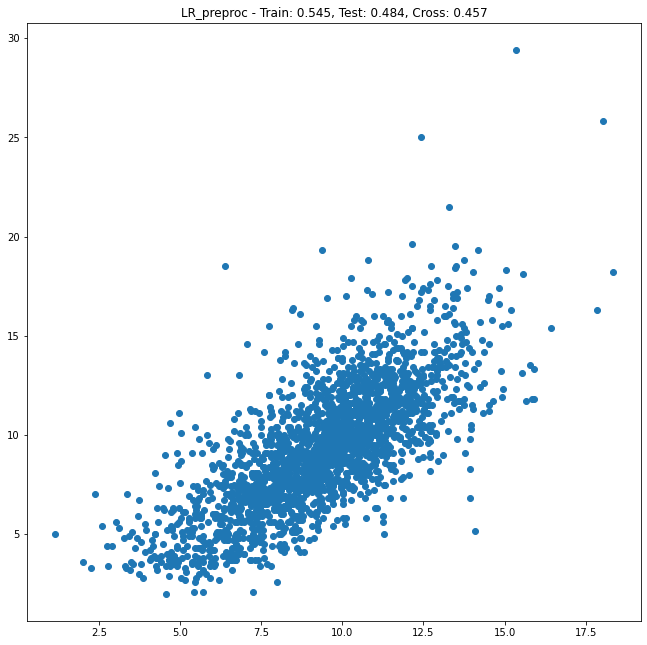

In [63]:

plt.figure(figsize=(11,11))
plt.scatter(lr.predict(Z_train), y_train)
plt.title('LR_preproc - Train: 0.545, Test: 0.484, Cross: 0.457')
plt.savefig('../graphs/LR_preproc_pred_scatter.jpg')

### Linear Regression PCA

In [58]:
df = pd.read_csv('../data/final_work_data.csv')

In [59]:
X = df.drop(columns = ['state', 'county_name', 'unemployment_rate_2010', 'population_total_2010'])
y = df['unemployment_rate_2010']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [61]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ss', StandardScaler()),
    ('pca', PCA()),
    ('model', LinearRegression())
])
params = {
    'pca__n_components': range(10,200,20)
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.score(X_test, y_test))
print(cross_val_score(gs, X_train, y_train).mean())
gs.best_params_

0.09329123454631678
0.21090043466563735
-2442.8702758045124


{'pca__n_components': 10}

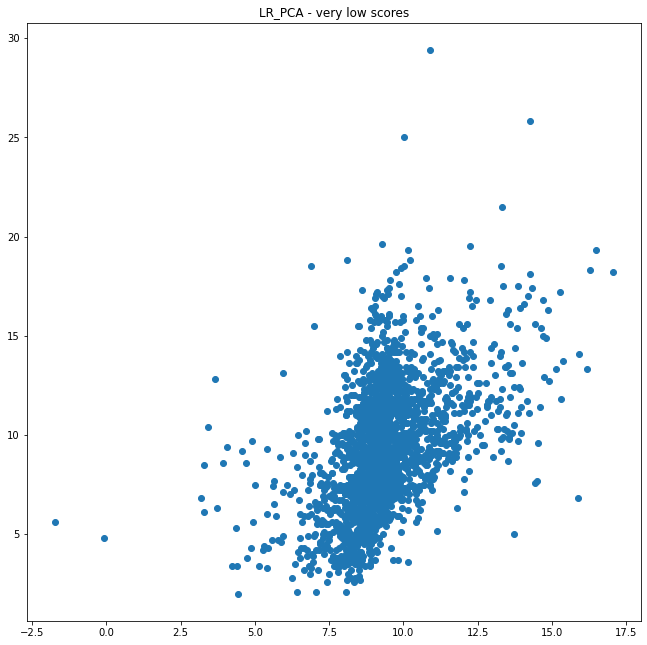

In [62]:
plt.figure(figsize=(11,11))
plt.scatter(gs.predict(X_train), y_train)
plt.title('LR_PCA - very low scores')
plt.savefig('../graphs/LR_PCA_pred_scatter.jpg')

### Neural network on linear regression initeraction data

In [32]:
df = pd.read_csv('../data/full_data_interaction_025_075.csv')

In [33]:
X = df.drop(columns = ['state', 'county_name', 'unemployment_rate_2010', 'population_total_2010'])
y = df['unemployment_rate_2010']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [36]:
in_shape = Z_train[0].shape
in_shape

(97,)

In [37]:
model_1 = Sequential()

model_1.add(Dense(128, activation= 'relu', input_shape= in_shape))
model_1.add(Dropout(.3))

model_1.add(BatchNormalization())
model_1.add(Dense(128, activation= 'relu'))

model_1.add(BatchNormalization())
model_1.add(Dense(64, activation= 'relu'))

model_1.add(Dense(32, activation= 'relu'))
model_1.add(Dropout(.5))

model_1.add(Dense(1, activation= None))

In [38]:
model_1.compile(optimizer= 'adam', loss= 'mse', metrics= ['mse', 'RootMeanSquaredError', 'MeanAbsolutePercentageError'])

In [39]:
history_1 = model_1.fit(Z_train, y_train,
          epochs= 300,
          validation_data= (Z_test, y_test),
          verbose= 1
         )

Epoch 1/300
71/71 [==============================] - 1s 3ms/step - loss: 45.6009 - mse: 45.6009 - root_mean_squared_error: 6.7528 - mean_absolute_percentage_error: 60.6868 - val_loss: 32.8380 - val_mse: 32.8380 - val_root_mean_squared_error: 5.7304 - val_mean_absolute_percentage_error: 50.2405
Epoch 2/300
71/71 [==============================] - 0s 2ms/step - loss: 15.7886 - mse: 15.7886 - root_mean_squared_error: 3.9735 - mean_absolute_percentage_error: 34.8515 - val_loss: 19.9764 - val_mse: 19.9764 - val_root_mean_squared_error: 4.4695 - val_mean_absolute_percentage_error: 39.1486
Epoch 3/300
71/71 [==============================] - 0s 3ms/step - loss: 12.9128 - mse: 12.9128 - root_mean_squared_error: 3.5934 - mean_absolute_percentage_error: 31.5733 - val_loss: 10.6354 - val_mse: 10.6354 - val_root_mean_squared_error: 3.2612 - val_mean_absolute_percentage_error: 25.1300
Epoch 4/300
71/71 [==============================] - 0s 2ms/step - loss: 12.1614 - mse: 12.1614 - root_mean_squared

Epoch 29/300
71/71 [==============================] - 0s 2ms/step - loss: 9.0228 - mse: 9.0228 - root_mean_squared_error: 3.0038 - mean_absolute_percentage_error: 25.3089 - val_loss: 4.3999 - val_mse: 4.3999 - val_root_mean_squared_error: 2.0976 - val_mean_absolute_percentage_error: 17.5660
Epoch 30/300
71/71 [==============================] - 0s 2ms/step - loss: 8.6030 - mse: 8.6030 - root_mean_squared_error: 2.9331 - mean_absolute_percentage_error: 24.8057 - val_loss: 4.2672 - val_mse: 4.2672 - val_root_mean_squared_error: 2.0657 - val_mean_absolute_percentage_error: 17.0660
Epoch 31/300
71/71 [==============================] - 0s 3ms/step - loss: 8.8654 - mse: 8.8654 - root_mean_squared_error: 2.9775 - mean_absolute_percentage_error: 25.4817 - val_loss: 4.3347 - val_mse: 4.3347 - val_root_mean_squared_error: 2.0820 - val_mean_absolute_percentage_error: 17.1841
Epoch 32/300
71/71 [==============================] - 0s 3ms/step - loss: 8.9203 - mse: 8.9203 - root_mean_squared_error: 2.

71/71 [==============================] - 0s 2ms/step - loss: 7.1458 - mse: 7.1458 - root_mean_squared_error: 2.6732 - mean_absolute_percentage_error: 22.9193 - val_loss: 3.8388 - val_mse: 3.8388 - val_root_mean_squared_error: 1.9593 - val_mean_absolute_percentage_error: 16.3008
Epoch 58/300
71/71 [==============================] - 0s 2ms/step - loss: 7.0566 - mse: 7.0566 - root_mean_squared_error: 2.6564 - mean_absolute_percentage_error: 22.3759 - val_loss: 4.0936 - val_mse: 4.0936 - val_root_mean_squared_error: 2.0233 - val_mean_absolute_percentage_error: 16.1401
Epoch 59/300
71/71 [==============================] - 0s 2ms/step - loss: 7.0751 - mse: 7.0751 - root_mean_squared_error: 2.6599 - mean_absolute_percentage_error: 22.3420 - val_loss: 3.9216 - val_mse: 3.9216 - val_root_mean_squared_error: 1.9803 - val_mean_absolute_percentage_error: 16.3898
Epoch 60/300
71/71 [==============================] - 0s 3ms/step - loss: 7.2435 - mse: 7.2435 - root_mean_squared_error: 2.6914 - mean_a

71/71 [==============================] - 0s 2ms/step - loss: 5.9134 - mse: 5.9134 - root_mean_squared_error: 2.4318 - mean_absolute_percentage_error: 20.9071 - val_loss: 3.8180 - val_mse: 3.8180 - val_root_mean_squared_error: 1.9540 - val_mean_absolute_percentage_error: 15.8094
Epoch 86/300
71/71 [==============================] - 0s 2ms/step - loss: 5.8046 - mse: 5.8046 - root_mean_squared_error: 2.4093 - mean_absolute_percentage_error: 19.9880 - val_loss: 3.9494 - val_mse: 3.9494 - val_root_mean_squared_error: 1.9873 - val_mean_absolute_percentage_error: 15.8738
Epoch 87/300
71/71 [==============================] - 0s 2ms/step - loss: 5.4921 - mse: 5.4921 - root_mean_squared_error: 2.3435 - mean_absolute_percentage_error: 19.3118 - val_loss: 4.1830 - val_mse: 4.1830 - val_root_mean_squared_error: 2.0452 - val_mean_absolute_percentage_error: 16.3365
Epoch 88/300
71/71 [==============================] - 0s 3ms/step - loss: 5.8784 - mse: 5.8784 - root_mean_squared_error: 2.4245 - mean_a

71/71 [==============================] - 0s 3ms/step - loss: 4.8061 - mse: 4.8061 - root_mean_squared_error: 2.1923 - mean_absolute_percentage_error: 18.2854 - val_loss: 3.7489 - val_mse: 3.7489 - val_root_mean_squared_error: 1.9362 - val_mean_absolute_percentage_error: 15.7968
Epoch 114/300
71/71 [==============================] - 0s 4ms/step - loss: 4.9228 - mse: 4.9228 - root_mean_squared_error: 2.2187 - mean_absolute_percentage_error: 18.0308 - val_loss: 3.6403 - val_mse: 3.6403 - val_root_mean_squared_error: 1.9080 - val_mean_absolute_percentage_error: 15.8320
Epoch 115/300
71/71 [==============================] - 0s 3ms/step - loss: 4.6285 - mse: 4.6285 - root_mean_squared_error: 2.1514 - mean_absolute_percentage_error: 17.8269 - val_loss: 4.0057 - val_mse: 4.0057 - val_root_mean_squared_error: 2.0014 - val_mean_absolute_percentage_error: 15.8242
Epoch 116/300
71/71 [==============================] - 0s 4ms/step - loss: 4.6683 - mse: 4.6683 - root_mean_squared_error: 2.1606 - mea

71/71 [==============================] - 0s 2ms/step - loss: 3.9426 - mse: 3.9426 - root_mean_squared_error: 1.9856 - mean_absolute_percentage_error: 16.0845 - val_loss: 3.5433 - val_mse: 3.5433 - val_root_mean_squared_error: 1.8824 - val_mean_absolute_percentage_error: 15.3136
Epoch 142/300
71/71 [==============================] - 0s 2ms/step - loss: 3.7160 - mse: 3.7160 - root_mean_squared_error: 1.9277 - mean_absolute_percentage_error: 16.2110 - val_loss: 3.6296 - val_mse: 3.6296 - val_root_mean_squared_error: 1.9051 - val_mean_absolute_percentage_error: 15.7790
Epoch 143/300
71/71 [==============================] - 0s 3ms/step - loss: 3.6966 - mse: 3.6966 - root_mean_squared_error: 1.9226 - mean_absolute_percentage_error: 15.8986 - val_loss: 3.6796 - val_mse: 3.6796 - val_root_mean_squared_error: 1.9182 - val_mean_absolute_percentage_error: 16.4395
Epoch 144/300
71/71 [==============================] - 0s 4ms/step - loss: 3.6847 - mse: 3.6847 - root_mean_squared_error: 1.9196 - mea

71/71 [==============================] - 0s 2ms/step - loss: 3.4065 - mse: 3.4065 - root_mean_squared_error: 1.8457 - mean_absolute_percentage_error: 15.3374 - val_loss: 3.7881 - val_mse: 3.7881 - val_root_mean_squared_error: 1.9463 - val_mean_absolute_percentage_error: 16.1317
Epoch 170/300
71/71 [==============================] - 0s 2ms/step - loss: 3.3274 - mse: 3.3274 - root_mean_squared_error: 1.8241 - mean_absolute_percentage_error: 15.3954 - val_loss: 3.6087 - val_mse: 3.6087 - val_root_mean_squared_error: 1.8997 - val_mean_absolute_percentage_error: 15.5963
Epoch 171/300
71/71 [==============================] - 0s 2ms/step - loss: 3.0459 - mse: 3.0459 - root_mean_squared_error: 1.7453 - mean_absolute_percentage_error: 14.9812 - val_loss: 3.6027 - val_mse: 3.6027 - val_root_mean_squared_error: 1.8981 - val_mean_absolute_percentage_error: 15.8873
Epoch 172/300
71/71 [==============================] - 0s 2ms/step - loss: 3.2305 - mse: 3.2305 - root_mean_squared_error: 1.7973 - mea

71/71 [==============================] - 0s 4ms/step - loss: 2.7662 - mse: 2.7662 - root_mean_squared_error: 1.6632 - mean_absolute_percentage_error: 14.3132 - val_loss: 3.4690 - val_mse: 3.4690 - val_root_mean_squared_error: 1.8625 - val_mean_absolute_percentage_error: 15.7429
Epoch 198/300
71/71 [==============================] - 0s 3ms/step - loss: 2.8208 - mse: 2.8208 - root_mean_squared_error: 1.6795 - mean_absolute_percentage_error: 14.3474 - val_loss: 3.4773 - val_mse: 3.4773 - val_root_mean_squared_error: 1.8648 - val_mean_absolute_percentage_error: 15.7945
Epoch 199/300
71/71 [==============================] - 0s 3ms/step - loss: 2.7262 - mse: 2.7262 - root_mean_squared_error: 1.6511 - mean_absolute_percentage_error: 14.1666 - val_loss: 3.4887 - val_mse: 3.4887 - val_root_mean_squared_error: 1.8678 - val_mean_absolute_percentage_error: 15.8922
Epoch 200/300
71/71 [==============================] - 0s 2ms/step - loss: 2.9847 - mse: 2.9847 - root_mean_squared_error: 1.7276 - mea

71/71 [==============================] - 0s 3ms/step - loss: 2.5442 - mse: 2.5442 - root_mean_squared_error: 1.5950 - mean_absolute_percentage_error: 13.8186 - val_loss: 3.6073 - val_mse: 3.6073 - val_root_mean_squared_error: 1.8993 - val_mean_absolute_percentage_error: 15.8525
Epoch 226/300
71/71 [==============================] - 0s 3ms/step - loss: 2.6901 - mse: 2.6901 - root_mean_squared_error: 1.6402 - mean_absolute_percentage_error: 13.7901 - val_loss: 3.5937 - val_mse: 3.5937 - val_root_mean_squared_error: 1.8957 - val_mean_absolute_percentage_error: 15.7563
Epoch 227/300
71/71 [==============================] - 0s 2ms/step - loss: 2.6223 - mse: 2.6223 - root_mean_squared_error: 1.6193 - mean_absolute_percentage_error: 14.2305 - val_loss: 3.7481 - val_mse: 3.7481 - val_root_mean_squared_error: 1.9360 - val_mean_absolute_percentage_error: 16.1704
Epoch 228/300
71/71 [==============================] - 0s 2ms/step - loss: 2.3723 - mse: 2.3723 - root_mean_squared_error: 1.5402 - mea

71/71 [==============================] - 0s 2ms/step - loss: 2.2451 - mse: 2.2451 - root_mean_squared_error: 1.4984 - mean_absolute_percentage_error: 13.3887 - val_loss: 3.5407 - val_mse: 3.5407 - val_root_mean_squared_error: 1.8817 - val_mean_absolute_percentage_error: 15.8294
Epoch 254/300
71/71 [==============================] - 0s 2ms/step - loss: 2.1015 - mse: 2.1015 - root_mean_squared_error: 1.4496 - mean_absolute_percentage_error: 13.1638 - val_loss: 3.6056 - val_mse: 3.6056 - val_root_mean_squared_error: 1.8988 - val_mean_absolute_percentage_error: 16.2620
Epoch 255/300
71/71 [==============================] - 0s 2ms/step - loss: 2.2670 - mse: 2.2670 - root_mean_squared_error: 1.5056 - mean_absolute_percentage_error: 13.3905 - val_loss: 3.5905 - val_mse: 3.5905 - val_root_mean_squared_error: 1.8949 - val_mean_absolute_percentage_error: 15.8072
Epoch 256/300
71/71 [==============================] - 0s 2ms/step - loss: 2.3587 - mse: 2.3587 - root_mean_squared_error: 1.5358 - mea

71/71 [==============================] - 0s 2ms/step - loss: 2.0586 - mse: 2.0586 - root_mean_squared_error: 1.4348 - mean_absolute_percentage_error: 12.9913 - val_loss: 3.5746 - val_mse: 3.5746 - val_root_mean_squared_error: 1.8907 - val_mean_absolute_percentage_error: 16.0351
Epoch 282/300
71/71 [==============================] - 0s 2ms/step - loss: 2.1255 - mse: 2.1255 - root_mean_squared_error: 1.4579 - mean_absolute_percentage_error: 13.2284 - val_loss: 3.6295 - val_mse: 3.6295 - val_root_mean_squared_error: 1.9051 - val_mean_absolute_percentage_error: 15.9644
Epoch 283/300
71/71 [==============================] - 0s 2ms/step - loss: 2.1071 - mse: 2.1071 - root_mean_squared_error: 1.4516 - mean_absolute_percentage_error: 12.8998 - val_loss: 3.6374 - val_mse: 3.6374 - val_root_mean_squared_error: 1.9072 - val_mean_absolute_percentage_error: 16.3027
Epoch 284/300
71/71 [==============================] - 0s 2ms/step - loss: 2.2751 - mse: 2.2751 - root_mean_squared_error: 1.5084 - mea

In [40]:
r2_score(y_train, model_1.predict(Z_train))

0.9105588565134765

In [41]:
r2_score(y_test, model_1.predict(Z_test))

0.6344849972715241

In [42]:
nn_train = model_1.predict(Z_train)
nn_test = model_1.predict(Z_test)
nn_train = [g[0] for g in nn_train]
nn_test = [h[0] for h in nn_test]

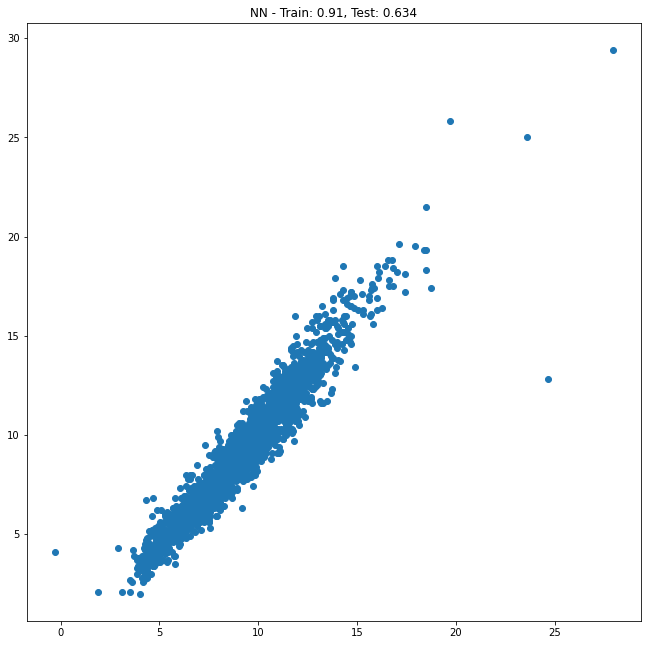

In [57]:
plt.figure(figsize=(11,11))
plt.scatter(model_1.predict(Z_train), y_train)
plt.title('NN - Train: 0.91, Test: 0.634')
plt.savefig('../graphs/NN_pred_scatter.jpg')

### Second level model based on linear regression and neural network preds

In [44]:
a =pd.DataFrame([lin_train, nn_train, y_train], index=['lin_reg', 'nn', 'y']).T
b = pd.DataFrame([lin_test, nn_test, y_test], index=['lin_reg', 'nn', 'y']).T

In [45]:
a.head()

,lin_reg,nn,y
0,10.922396,10.932160,11.7
1,7.817903,7.955190,9.9
2,12.166780,9.110406,8.0
3,12.499178,10.799421,11.6
4,9.030794,6.749950,7.4


In [46]:
b.head()

,lin_reg,nn,y
0,12.136029,11.611511,12.5
1,10.070358,8.201416,5.9
2,11.389406,10.266273,10.7
3,7.893248,7.195796,6.3
4,12.921743,11.365313,12.4


In [47]:
Xa = a.drop(columns='y')
ya = a['y']
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, random_state=42)

In [48]:
lev2 = LinearRegression()

In [49]:
lev2.fit(Xa_train, ya_train)

LinearRegression()

In [50]:
lev2.score(Xa_train, ya_train), lev2.score(Xa_test, ya_test), cross_val_score(lev2, Xa_train, ya_train).mean()

(0.9215131118635261, 0.935026581601892, 0.920982149145415)

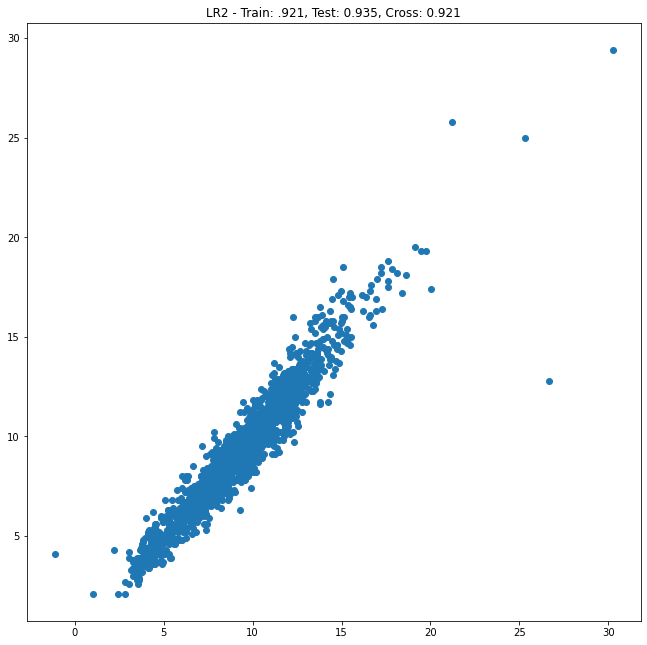

In [56]:
plt.figure(figsize=(11,11))
plt.scatter(lev2.predict(Xa_train), ya_train)
plt.title('LR2 - Train: .921, Test: 0.935, Cross: 0.921')
plt.savefig('../graphs/LR2_pred_scatter.jpg')

These scores are scarring us

In [52]:
#Unseen data test data from lvl 1
lev2.score(b.drop(columns='y'), b['y'])

0.6417903426228939

In [ ]:
#(0.9009880466719563, 0.6166400989225644, 0.8996610030098859)
#(0.8909971442563475, 0.5768477536960713, 0.888529811837276)
#(0.8841509454257197, 0.5772424027671583, 0.8834176035984036)

#(0.9118854053242108, 0.9288400370503621, 0.9114631988363131)